Внимательно прочтите эти инструкции. Выполнение **всех** этих пунктов - обязательно для получения баллов за задание.

1) Проверка
    - После того, как вы допишете код
        - очистите все клетки (`Cell > All Output > Clear`)
        - выполните все клетки подряд (`Cell > Run All`)
    - Выполнение должно пройти без ошибок
    - Сохраните ноутбук с выполненными клетками

<!-- -->

2) Отправка в тестовую систему
    - Когда вы готовы сдать ноутбук, загрузите его в тестовую систему (fall.cv-gml.ru)
    - В тестовую систему нужно загружать только сам `.ipynb` ноутбук
        - Не нужно его `zip`овать
        - Не нужно его конвертировать в `pdf` или `html`
    - После загрузки в тестовую систему там появится ссылка для просмотра загруженного решения
        - Проверьте, что вы загрузили в тестовую систему то, что хотели
        - Проверьте, что в системе отображаются результаты выполнения всех клеток

## Дифференцируемая растеризация

Необходимо реализовать процедуру оптимизации текстуры из входных изображений с позами камер, считая что сэмплированная текстура и есть результат шейдинга. Код загрузки данных вам предоставлен, рекомендуется внимательно его изучить. Вам необходимо имплементировать процедуру рендеринга текстурированного меша используя примитивы [nvdiffrast](https://nvlabs.github.io/nvdiffrast/).

Работы оцениваются по бинарному принципу (зачет/незачет).

In [1]:
%%bash

# Download dataset and helper library
for part in data lib; do
    if [ ! -d "${part}/" ]; then
        curl -sO "https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/differentiable-rasterization/${part}.zip"
        unzip -qo "${part}.zip"
    fi
done

# Install required dependencies
if ! pip freeze | grep -q nvdiffrast; then
    pip install -q \
        git+https://github.com/NVlabs/nvdiffrast.git \
        ninja xatlas trimesh \
        torch matplotlib
fi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.9/708.9 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import nvdiffrast.torch as dr
import torch
import torch.nn.functional as Func

glctx = dr.RasterizeCudaContext()

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [3]:
from lib.dataset import DatasetNERF

dataset = DatasetNERF(cfg="./data/hotdog/transforms_train.json", resolution=(400, 400))

In [4]:
def render_textured(
    mesh,
    mvp,
    resolution=(800, 800),
    texture=None,
    enable_mip=True,
    max_mip_level=9,
    device='cuda',
):
    """
    Необходимо реализовать пайплайн растеризации текстурированного меша используя примитивы nvdiffrast

        @params: mesh -- dataset.mesh, Меш, состоящий из набора вершин и граней. Для кажой
            вершины текстурные координаты заданы
        @params: mvp -- Model-View-Projection преобразование в виде единой матрицы 4x4
        @params: resolution -- разрешение, в котором рендерить
        @params: texture -- оптимизируемая текстура
        @params: enable_mip -- флаг включения MIP-mapping при семплировании текстур
        @params: max_mip_level -- максимальное количесвто MIP уровней

        Return: Color, Mask -- отрендеренный кадр, маска отрендеренных пикселей для расчета лосса

    """
    device = device
    if texture is not None:
        texture = texture.to(device)
    verts = mesh.verts.to(device)
    uvs = mesh.uvs.to(device)
    faces = mesh.faces.int().to(device)
    mvp = mvp.to(device)

    # Vertex processing
    verts_hom = torch.cat([verts, torch.ones_like(verts[:, :1], device=device)], dim=1)
    verts_processed = torch.mm(verts_hom, mvp[0, ...].T)
    verts_processed = verts_processed.unsqueeze(0)

    # Rasterize
    rast, db = dr.rasterize(glctx, verts_processed, faces, resolution=resolution)

    # Interpolate UV
    uvs, texd = dr.interpolate(uvs, rast, faces, db, diff_attrs='all')

    # Sample texture with/without mipmapping
    if texture is None:
        color = rast
    elif not enable_mip:
        color = dr.texture(texture.unsqueeze(0), uvs, texd, filter_mode='linear')
    else:
        color = dr.texture(texture.unsqueeze(0), uvs, texd, filter_mode='linear-mipmap-linear', max_mip_level=max_mip_level)

    # Antialiasing
    color = dr.antialias(color, rast, verts_processed, faces)

    mask = (rast[..., 3:] > 0).float()

    return color[..., :3] * mask, mask

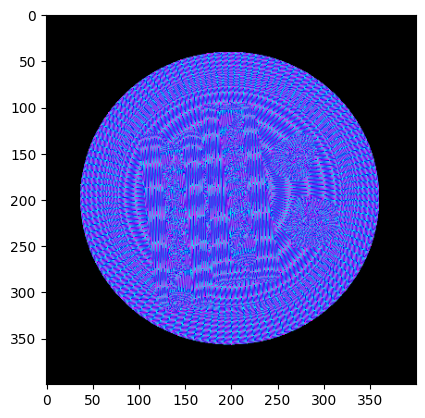

In [5]:
c, _ = render_textured(
    dataset.mesh,
    dataset[0]["mvp"],
    dataset.resolution,
)
plt.imshow(c[0].detach().cpu());

Ожидаемый результат:

<img src="https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/differentiable-rasterization/ref_notexture.png" style="display: inline-block; text-align: left;"/>

In [6]:
texture = torch.full([512, 512, 3], 0.5, device="cuda", requires_grad=True)
optimizer = torch.optim.Adam([texture], lr=1e-3)

In [7]:
########################################
########################################
## Написать цикл Оптимизации текстуры ##
########################################
########################################
############## ####### #################
############## ####### #################
########### ############ ###############
############ ########## ################
############# ######## #################
############## ###### ##################
############### ### ####################
################ # #####################
########################################
import tqdm
device = 'cuda'

epochs = 15

for i, data in (pbar := tqdm.tqdm(enumerate(dataset), total=len(dataset) * epochs)):
    optimizer.zero_grad()
    clr, mask = render_textured(
        dataset.mesh,
        data['mvp'],
        dataset.resolution,
        texture=texture,
        enable_mip=False,
        device=device
    )
    gt = data['img'].to(device)
    loss = torch.mean((clr - gt) ** 2 * mask)
    loss.backward()
    optimizer.step()
    pbar.set_description(f'Итерация номер {i}/{len(dataset) * epochs}, Loss {loss.item()}')
    if i >= len(dataset) * epochs:
        break
texture = torch.clip(texture, 0, 1)

Итерация номер 1500/1500, Loss 0.00042814522748813033: 100%|██████████| 1500/1500 [00:10<00:00, 141.80it/s]


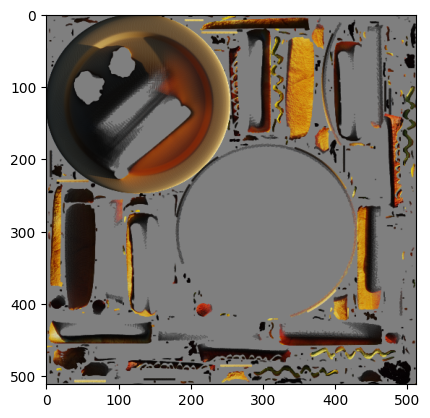

In [8]:
plt.imshow(texture.detach().cpu());

Ожидаемый результат:

<img src="https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/differentiable-rasterization/ref_texture.png" style="display: inline-block; text-align: left;"/>

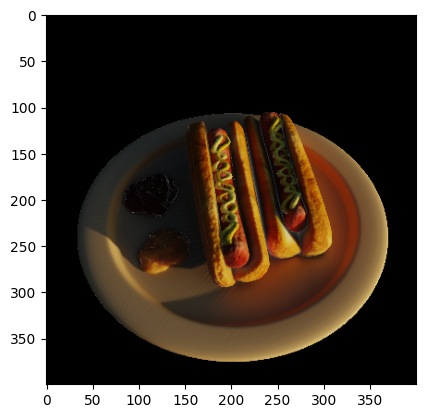

In [9]:
c, _ = render_textured(
    dataset.mesh,
    dataset[90]["mvp"],
    dataset.resolution,
    texture=texture,
)
plt.imshow(c[0].detach().cpu());

Ожидаемый результат:

<img src="https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/differentiable-rasterization/ref_render.png" style="display: inline-block; text-align: left;"/>